In [1]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import collections
import pandas as pd
from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from pygsp import utils
from pygsp import graphs, filters

In [2]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','CCS':'C','AC5':'L'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

amino_bulkiness = {'A':11.5, 'D':11.68,'C':13.46,'E':13.57,'F':19.8,'G':3.4,'H':13.67,'I':21.4,'K':15.71,'L':21.4,
                   'M':16.25,'N':12.82,'P':17.43,'Q':14.45,'R':14.28,'S':9.47,'T':15.77,'V':21.57,'W':21.61,'Y':18.03}

amino_polarity = {'A':0, 'D':49.7,'C':1.48,'E':49.9,'F':0.35,'G':0,'H':51.6,'I':0.1,'K':49.5,'L':0.13,
                   'M':1.43,'N':3.38,'P':1.58,'Q':3.53,'R':52,'S':1.67,'T':1.66,'V':0.13,'W':2.1,'Y':1.61}

amino_turn_tendency = {'A':0.66, 'D':1.46,'C':1.19,'E':0.74,'F':0.6,'G':1.56,'H':0.95,'I':0.47,'K':1.01,'L':0.59,
                   'M':0.6,'N':1.56,'P':1.52,'Q':0.98,'R':0.95,'S':1.43,'T':0.96,'V':0.5,'W':0.96,'Y':1.14}

amino_coil_tendency = {'A':0.71, 'D':1.21,'C':1.19,'E':0.84,'F':0.71,'G':1.52,'H':1.07,'I':0.66,'K':0.99,'L':0.69,
                   'M':0.59,'N':1.37,'P':1.61,'Q':0.87,'R':1.07,'S':1.34,'T':1.08,'V':0.63,'W':0.76,'Y':1.07}

amino_flexibility = {'A':0, 'D':2,'C':1,'E':3,'F':2,'G':0,'H':2,'I':2,'K':4,'L':2,
                   'M':3,'N':2,'P':0,'Q':3,'R':5,'S':1,'T':1,'V':1,'W':2,'Y':2}

amino_partial_specific_volume = {'A':60.46, 'D':73.83,'C':67.7,'E':85.88,'F':121.48,'G':43.25,'H':98.79,
                                 'I':107.72,'K':108.5,
                                 'L':107.75,'M':105.35,'N':78.01,'P':82.83,'Q':93.9,
                                 'R':127.34,'S':60.62,'T':76.83,'V':90.78,'W':143.91,'Y':123.6}

amino_compressibility = {'A':-25.5, 'D':-33.12,'C':-32.82,'E':-36.17,'F':-34.54,'G':-27,'H':-31.84,
                        'I':-31.78,'K':-32.4,
                        'L':-31.78,'M':-31.18,'N':-30.9,'P':-23.25,'Q':-32.6,
                        'R':-26.62,'S':-29.88,'T':-31.23,'V':-30.62,'W':-30.24,'Y':-35.01}

amino_refractive_index = {'A':14.34, 'D':12,'C':35.77,'E':17.26,'F':29.4,'G':0,'H':21.81,
                        'I':19.06,'K':21.29,
                        'L':18.78,'M':21.64,'N':13.28,'P':10.93,'Q':17.56,
                        'R':26.66,'S':6.35,'T':11.01,'V':13.92,'W':42.53,'Y':31.55}

amino_Solvent_accessible_surface_area_for_protein_unfolding = {'A':70.9, 'D':69.6,'C':114.3,'E':80.5,'F':148.4,'G':44,'H':107.9,
                        'I':142.7,'K':87.5,
                        'L':129.8,'M':147.9,'N':74,'P':73.5,'Q':93.3,
                        'R':116,'S':62.8,'T':78,'V':115.6,'W':167.8,'Y':145.9}


amino_Average_number_of_surrounding_residues = {'A':6.05, 'D':4.95,'C':7.86,'E':5.1,'F':6.62,'G':6.16,'H':5.8,
                        'I':7.51,'K':4.88,
                        'L':7.37,'M':6.39,'N':5.04,'P':5.65,'Q':5.45,
                        'R':5.7,'S':5.53,'T':5.81,'V':7.62,'W':6.98,'Y':6.73}

amino_Solvent_accessible_surface_area_for_native_protein = {'A':33.2, 'D':62.4,'C':17.9,'E':81,'F':33.1,'G':29.2,'H':57.7,
                        'I':28.3,'K':107.5,
                        'L':31.1,'M':41.3,'N':60.5,'P':60.7,'Q':71.5,
                        'R':94.5,'S':48.7,'T':52,'V':28.1,'W':39.5,'Y':50.4}


In [226]:
def crawl_pdb(path):
    '''This function reads pdb files and stores their distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path  + pdb )
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        if residue.get_resname() in amino_lookup:
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
#         print(np.unique(labels))
        info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
    G = graphs.Graph(distance_matrix, lap_type='normalized')
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, pdb, signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'bulkiness':
        s = np.asarray([amino_bulkiness[aa] for aa in seq])
    elif signal == 'polarity':
        s = np.asarray([amino_polarity[aa] for aa in seq])
    elif signal == 'turn_tendency':
        s = np.asarray([amino_turn_tendency[aa] for aa in seq])
    elif signal == 'coil_tendency':
        s = np.asarray([amino_coil_tendency[aa] for aa in seq])
    elif signal == 'flexibility':
        s = np.asarray([amino_flexibility[aa] for aa in seq])
    elif signal == 'partial_specific_volume':
        s = np.asarray([amino_partial_specific_volume[aa] for aa in seq])
    elif signal == 'compressibility':
        s = np.asarray([amino_compressibility[aa] for aa in seq])
    elif signal == 'refractive_index':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'amino_Solvent_accessible_surface_area_for_protein_unfolding':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'amino_Average_number_of_surrounding residues':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'amino_Solvent_accessible_surface_area_for_native_protein':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'conservation_score':
        #https://compbio.cs.princeton.edu/conservation/
        filename = pdb.split('.')[0]
#         cmd = ['python3 ./pdb2fasta-master/pdb2fasta.py '+pdb_path+''+pdb+' > ./pdb2fasta-master/'+filename+'.fasta']
#         print(cmd)
#         process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with open('./pdb2fasta-master/'+filename+'.fasta', 'w') as the_file:
            the_file.write('>'+filename+':A\n'+seq+"-")
        process = 0
        if process ==0:
            s = []
            cmd = ['python2 ./pdb2fasta-master/conservation_code/score_conservation.py -alignfile ./pdb2fasta-master/'+filename+'.fasta > ./pdb2fasta-master/'+filename+'.csv']
#             print(cmd)
            process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if process ==0:
                with open('./pdb2fasta-master/'+filename+'.csv') as f:
                    for i in range(5):
                        next(f)
                    for line in f:
#                         print(line.split("\t")[1])
                        s.append(float(line.split("\t")[1]))
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s


def get_filtered_signal(G, signal, cutoff,type_spatial):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        for j in range(signal_filtered_hat.shape[1]):
                p = np.percentile(signal_filtered_hat[:,j], 70) 
                signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
#         inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
        signal_filtered_hat = np.mean(np.abs(signal_filtered_hat),axis=0)
        return signal_filtered_hat

In [4]:
signals_wavelet = []
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 'residue_count', 'clustering_coeff','conservation_score','bulkiness', 'polarity', 'turn_tendency' , 'coil_tendency' , 'flexibility', 'partial_specific_volume','refractive_index','compressibility','amino_Solvent_accessible_surface_area_for_protein_unfolding','amino_Average_number_of_surrounding residues','amino_Solvent_accessible_surface_area_for_native_protein']
for i in signals:
    for j in range(1,5):
        signals_wavelet.append(i+"_"+str(j))

In [227]:
path = './pdb_files/ant_real/'
pdbinfo_dict = crawl_pdb(path)
lfc_cutoff = 0.42
model = 'weighted-rig'
# print (lfc_cutoff, end=' : ')
gsp_features = pd.DataFrame(columns=signals_wavelet+['class'])

path_files = './pdb_files/ant_real/'
for pdb in pdbinfo_dict.keys():
    row = []
    c=0
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,lfc_cutoff,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb.split(".")[0]] = row

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4092.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4126.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4160.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4211.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4344.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5062.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5103.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5144.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5349.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4930.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13462.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13487.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13512.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 13537.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 13562.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8804.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8831.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8838.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8850.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8882.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12529.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 25061.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 25088.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 25115.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 25142.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4082.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4167.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4251.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4365.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3445.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8336.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8396.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8456.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6240.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11938.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3944.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4027.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4110.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4201.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10656.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 10540.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10547.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 10646.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 10925.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7226.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structur

In [228]:
path = './pdb_files/ago_real/'
pdbinfo_dict_1 = crawl_pdb(path)

model = 'weighted-rig'
print (lfc_cutoff, end=' : ')
gsp_features_1 = pd.DataFrame(columns=signals_wavelet+['class'])
path_files = './pdb_files/ago_real/'
for pdb in pdbinfo_dict_1.keys():
    row = []
    c=1
    G = get_graph(pdbinfo_dict_1[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict_1[pdb]['sequence'],pdb, signal=signal_name)
        value = get_filtered_signal(G,signal,lfc_cutoff,type_spatial='wavelet') 
        row.extend(value)
    row.append(c)
    gsp_features_1.loc[pdb.split(".")[0]] = row

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9024.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9046.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain U is discontinuous at line 9071.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain X is discontinuous at line 9093.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9118.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4394.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4419.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4443.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4513.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4605.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4358.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4391.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4440.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4443.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4335.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15566.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15588.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15617.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15639.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 15668.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6319.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6434.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6558.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6595.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3998.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4858.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4885.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4912.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4991.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8407.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4737.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4791.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4731.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4783.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4835.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2478.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2571.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4982.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5110.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17412.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2324.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4588.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4606.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4624.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4791.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14681.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14725.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14729.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14773.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14777.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8691.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8769.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8827.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8929.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4835.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15981.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16039.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 16097.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 16155.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16213.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 66223.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 66242.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 66266.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 66280.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 66309.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 24288.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 24302.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 24395.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 24409.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 24502.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17130.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17149.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17177.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17191.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17205.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4836.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4955.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4854.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4948.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4555.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9608.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3555.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3567.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6979.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6986.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9238.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9282.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9326.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9370.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8715.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 46205.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 46263.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 46321.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 46379.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 25256.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2592.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2827.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4444.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4479.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4514.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8370.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8410.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8456.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8496.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8542.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7623.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7665.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7707.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7709.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10785.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6170.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6289.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6953.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7011.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7041.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8997.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9135.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11250.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11280.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11310.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structure

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5740.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5771.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5802.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5833.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5864.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7535.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7631.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7727.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7779.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8624.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8207.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8736.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8815.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8876.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8881.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 24081.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 24389.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 24020.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 24061.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23747.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9679.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain N is discontinuous at line 9788.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9790.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain N is discontinuous at line 9807.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5002.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain R is discontinuous at line 10655.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12326.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12394.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12462.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12464.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

0.42 : 

/home/cellsearch/py_36_env/lib/python3.6/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [229]:
from sklearn.model_selection import train_test_split
gsp_features['class'] = 0
gsp_features_1['class'] = 1
# gsp_f = pd.read_csv("./gsp_features.txt",sep="\t",index_col=0)
gsp_f = pd.concat([gsp_features,gsp_features_1],axis=0)

X = gsp_f[gsp_f.columns.difference(['class'])]
y = gsp_f['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=109)

In [ ]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report

#Create a svm Classifier
clf = svm.SVC(kernel='poly',degree=50) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

from sklearn.metrics import f1_score
print("F1 score : ",metrics.f1_score(y_test, y_pred, labels=np.unique(y_pred)))

# print classification report 
print(classification_report(y_test, y_pred)) 

In [113]:
gsp_f.to_csv('./gsp_features.txt',sep="\t")

In [62]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.7678571428571429
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        17
           1       0.80      0.90      0.84        39

    accuracy                           0.77        56
   macro avg       0.73      0.68      0.70        56
weighted avg       0.76      0.77      0.75        56



In [27]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
clf = BaggingClassifier(base_estimator=SVC(kernel='poly',degree=25),n_estimators=5, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8035714285714286
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.82      0.92      0.87        39

    accuracy                           0.80        56
   macro avg       0.78      0.73      0.74        56
weighted avg       0.80      0.80      0.79        56



In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01,max_depth=1, random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred))

ACCURACY OF THE MODEL:  0.6607142857142857
              precision    recall  f1-score   support

           0       0.33      0.12      0.17        17
           1       0.70      0.90      0.79        39

    accuracy                           0.66        56
   macro avg       0.52      0.51      0.48        56
weighted avg       0.59      0.66      0.60        56



# LIGANDS DATA

In [8]:
signals_wavelet_ligand = []
signals_ligand = ['molecular_weight_ligand', 'hydrophobicity_ligand', 'node_degree_ligand', 'node_weighted_degree_ligand', 'residue_count_ligand', 'clustering_coeff_ligand','conservation_score_ligand','bulkiness_ligand', 'polarity_ligand', 'turn_tendency_ligand' , 'coil_tendency_ligand' , 'flexibility_ligand', 'partial_specific_volume_ligand','refractive_index_ligand','compressibility_ligand','amino_Solvent_accessible_surface_area_for_protein_unfolding_ligand','amino_Average_number_of_surrounding residues','amino_Solvent_accessible_surface_area_for_native_protein']
for i in signals_ligand:
    for j in range(1,5):
        signals_wavelet_ligand.append(i+"_"+str(j))

In [56]:
import pickle
with open('./files2/ant_dic.pkl', 'rb') as f:
    pdbinfo_dict = pickle.load(f)

model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet_ligand+['class'])

for pdb in pdbinfo_dict.keys():
    row = []
    c=0
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb, signal=signal_name)
        value = get_filtered_signal(G,signal,lfc_cutoff,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb.split(".")[0]] = row

In [57]:
with open('./files2/ago_dic.pkl', 'rb') as f:
    pdbinfo_dict_1 = pickle.load(f)
    
model = 'weighted-rig'
print (lfc_cutoff, end=' : ')
gsp_features_1 = pd.DataFrame(columns=signals_wavelet_ligand+['class'])

for pdb in pdbinfo_dict_1.keys():
#         print (pdb, end=', ')
    row = []
    c=1
    G = get_graph(pdbinfo_dict_1[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict_1[pdb]['sequence'],pdb, signal=signal_name)
        value = get_filtered_signal(G,signal,lfc_cutoff,type_spatial='wavelet')       
        row.extend(value)        
    row.append(c)
    gsp_features_1.loc[pdb.split(".")[0]] = row

0.42 : 

In [58]:
gsp_f_ligand = pd.concat([gsp_features,gsp_features_1],axis=0)

X = gsp_f_ligand[gsp_f_ligand.columns.difference(['class'])]
y = gsp_f_ligand['class']

In [42]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Create a svm Classifier
clf = svm.SVC(kernel='poly',degree=50,probability=True) # Linear Kernel

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test, y_pred)) 

Accuracy: 0.7857142857142857
Precision: 0.8
Recall: 0.9230769230769231
              precision    recall  f1-score   support

         0.0       0.73      0.47      0.57        17
         1.0       0.80      0.92      0.86        39

    accuracy                           0.79        56
   macro avg       0.76      0.70      0.71        56
weighted avg       0.78      0.79      0.77        56



In [11]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.7857142857142857
              precision    recall  f1-score   support

         0.0       0.69      0.53      0.60        17
         1.0       0.81      0.90      0.85        39

    accuracy                           0.79        56
   macro avg       0.75      0.71      0.73        56
weighted avg       0.78      0.79      0.78        56



MCC score :  0.5297963651904801
AUC :  0.7991769547325103


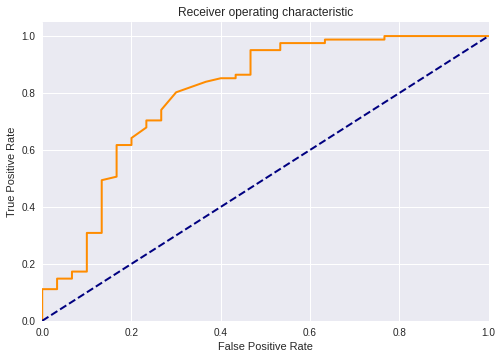

              precision    recall  f1-score   support

         0.0       0.82      0.47      0.60        30
         1.0       0.83      0.96      0.89        81

    accuracy                           0.83       111
   macro avg       0.83      0.71      0.74       111
weighted avg       0.83      0.83      0.81       111



In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)

y_pred = clf.predict(X_test)
print("MCC score : ",matthews_corrcoef(y_test, y_pred))

lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print("AUC : ",roc_auc_score(y_test, lr_probs))
lw = 2
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
print(classification_report(y_test, y_pred)) 

In [17]:
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

clf = AdaBoostClassifier(n_estimators=1000, random_state=0)
clf.fit(X_train, y_train)

# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.6607142857142857
              precision    recall  f1-score   support

         0.0       0.43      0.35      0.39        17
         1.0       0.74      0.79      0.77        39

    accuracy                           0.66        56
   macro avg       0.58      0.57      0.58        56
weighted avg       0.64      0.66      0.65        56



# combined sequence and ligand

In [59]:
X1 = gsp_f[gsp_f.columns.difference(['class'])]
X2 = gsp_f_ligand[gsp_f_ligand.columns.difference(['class'])]
Y1 = gsp_f['class']
gsp_all = pd.concat([X1,X2,Y1],axis=1)

X = gsp_all[gsp_all.columns.difference(['class'])]
y = gsp_all['class']

In [164]:
d2 = np.load("./data_vib.npy",allow_pickle=True)
d1 = np.load("./dat2a.npy",allow_pickle=True)
d1 = pd.DataFrame(d1)
ind = []
for i in range(d1.shape[0]):
    ind.append(list(d1.loc[i,2])[0][0].split("_")[0])
d1.index = ind
d1 = d1.drop(index= '1D0W')
b = {x[0] : x[1:] for x in d2}
f1 = ['AAC', 'CKSAAP', 'DPC', 'DDE', 'TPC','GAAC', 'CKSAAGP', 'GTPC','NMBroto', 'Moran', 'Geary','CTDC', 'CTDT', 'CTDD','CTriad', 'KSCTriad','SOCNumber', 'QSOrder','PAAC', 'APAAC']
other_features= pd.DataFrame(index=b.keys(),columns=f1)
for i in X.index:
    to_f = i.split(".")[0]
#     print(len(b[to_f]))
    for j in range(d1.shape[1]):
#         print(np.sum(pd.to_numeric(pd.Series(np.ravel(d1.loc[to_f,j])[1:]), errors='coerce').dropna()))
        other_features.loc[to_f][f1[j]] = np.abs(np.sum(pd.to_numeric(pd.Series(np.ravel(d1.loc[to_f,j])[1:]), errors='coerce').dropna()))

In [230]:
# X.index = [i.split('.')[0] for i in X.index]
X1 = pd.merge(gsp_f, other_features,right_index=True,left_index=True)
X = X1[X1.columns.difference(['class'])]
y = X1['class']

In [65]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Create a svm Classifier
clf = svm.SVC(kernel='poly',degree=50,probability=True) # Linear Kernel

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test, y_pred)) 

Accuracy: 0.5892857142857143
Precision: 0.7105263157894737
Recall: 0.6923076923076923
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        17
           1       0.71      0.69      0.70        39

    accuracy                           0.59        56
   macro avg       0.52      0.52      0.52        56
weighted avg       0.60      0.59      0.59        56



In [193]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
clf = BaggingClassifier(base_estimator=ExtraTreesClassifier(n_estimators=100, max_depth=100,min_samples_split=5, random_state=0),n_estimators=100, random_state=0).fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test, y_pred)) 

Accuracy: 0.8035714285714286
Precision: 0.8181818181818182
Recall: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.82      0.92      0.87        39

    accuracy                           0.80        56
   macro avg       0.78      0.73      0.74        56
weighted avg       0.80      0.80      0.79        56



In [190]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.7857142857142857
              precision    recall  f1-score   support

           0       0.73      0.47      0.57        17
           1       0.80      0.92      0.86        39

    accuracy                           0.79        56
   macro avg       0.76      0.70      0.71        56
weighted avg       0.78      0.79      0.77        56




ACCURACY OF THE MODEL:  0.755656108597285
              precision    recall  f1-score   support

           0       0.60      0.51      0.55        65
           1       0.81      0.86      0.83       156

    accuracy                           0.76       221
   macro avg       0.70      0.68      0.69       221
weighted avg       0.75      0.76      0.75       221



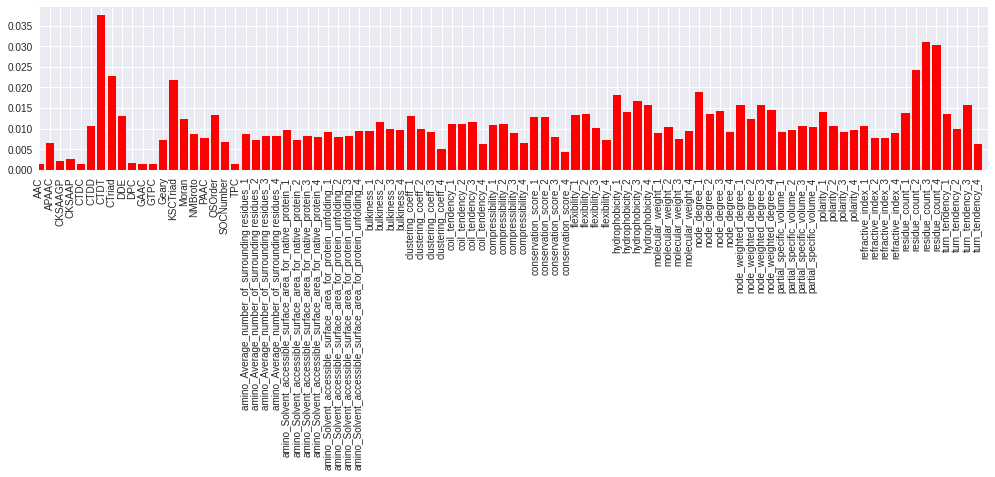

Accuracy: 0.76 (+/- 0.12)


In [265]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=109)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 

#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(17,3))
importance = clf.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance,color='red')
pyplot.xlim([0,importance.size])
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,X.columns, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [110]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=100, min_samples_split=10,random_state=0)
clf.fit(X_train, y_train) 

# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.7857142857142857
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        17
           1       0.81      0.90      0.85        39

    accuracy                           0.79        56
   macro avg       0.75      0.71      0.73        56
weighted avg       0.78      0.79      0.78        56



In [189]:
clf = ExtraTreesClassifier(n_estimators=100, max_depth=100,min_samples_split=5, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)

clf.fit(X_train, y_train) 

# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.8035714285714286
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.82      0.92      0.87        39

    accuracy                           0.80        56
   macro avg       0.78      0.73      0.74        56
weighted avg       0.80      0.80      0.79        56



MCC score :  0.5568484691395958
AUC :  0.799396681749623


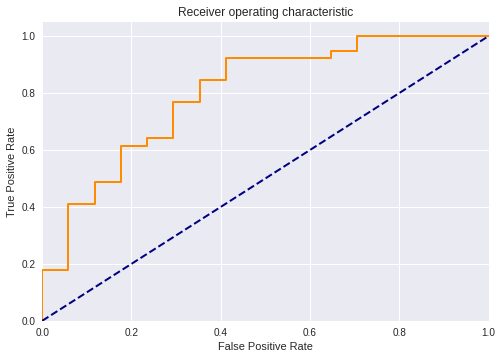

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        17
           1       0.84      0.92      0.88        39

    accuracy                           0.82        56
   macro avg       0.80      0.76      0.77        56
weighted avg       0.82      0.82      0.81        56



In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
y_pred = clf.predict(X_test)
print("MCC score : ",matthews_corrcoef(y_test, y_pred))

lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print("AUC : ",roc_auc_score(y_test, lr_probs))
lw = 2
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
print(classification_report(y_test, y_pred)) 

In [188]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimators = [
     ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
     ('svr',ExtraTreesClassifier(n_estimators=100, max_depth=100,min_samples_split=5, random_state=0))
 ]
clf = StackingClassifier(
     estimators=estimators, final_estimator=DecisionTreeClassifier(max_depth=100, min_samples_split=10,random_state=0)
 )
clf.fit(X_train, y_train)

# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.7321428571428571
              precision    recall  f1-score   support

           0       0.55      0.65      0.59        17
           1       0.83      0.77      0.80        39

    accuracy                           0.73        56
   macro avg       0.69      0.71      0.70        56
weighted avg       0.75      0.73      0.74        56



# ---------------------------------Final Model --------------------------------------------------------


              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.84      0.95      0.89        39

    accuracy                           0.84        56
   macro avg       0.84      0.77      0.79        56
weighted avg       0.84      0.84      0.83        56

MCC score :  0.6016948197835039
AUC :  0.8024132730015083


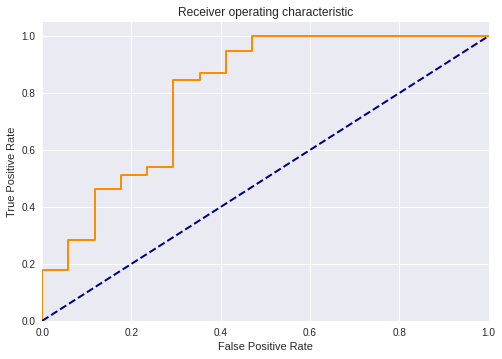

In [233]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)

clf1 = ExtraTreesClassifier(n_estimators=100, max_depth=100,min_samples_split=5, random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=100, random_state=0)

eclf3 = VotingClassifier(estimators=[('et', clf1), ('rf', clf2), ('gb', clf3)],voting='soft', weights=[2,1,4],flatten_transform=True)
eclf3 = eclf3.fit(X_train, y_train)

# performing predictions on the test dataset 
y_pred = eclf3.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 

# print classification report 
print(classification_report(y_test, y_pred)) 

y_pred = eclf3.predict(X_test)
print("MCC score : ",matthews_corrcoef(y_test, y_pred))

lr_probs = eclf3.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print("AUC : ",roc_auc_score(y_test, lr_probs))
lw = 2
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [286]:
from sklearn import metrics 
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)

    clf1 = ExtraTreesClassifier(n_estimators=100, max_depth=100,min_samples_split=5, random_state=0)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
    clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=100, random_state=0)

    eclf3 = VotingClassifier(estimators=[('et', clf1), ('rf', clf2), ('gb', clf3)],voting='soft', weights=[2,1,4],flatten_transform=True)
    eclf3 = eclf3.fit(X_train, y_train)

    # performing predictions on the test dataset 
    y_pred = eclf3.predict(X_test) 

    scores.append(metrics.accuracy_score(y_test, y_pred))
print("accuracy :",np.mean(scores))

accuracy : 0.8392857142857142


# -------------------------------------------------------------------------------------------------

In [195]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.001,max_depth=100, random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8035714285714286
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.83      0.90      0.86        39

    accuracy                           0.80        56
   macro avg       0.77      0.74      0.75        56
weighted avg       0.80      0.80      0.80        56



In [149]:
a = ["2Q0A","4D7S","3NEF","5ZCU","3NMH","3QT0","5UC1","3H52","1QKT","5TOA","3B7D","4F1Y"]
import pickle
with open('./sm_w2v2.pkl', 'rb') as f:
    dik = pickle.load(f)
y=[]
x = []
for i,num in enumerate(dik):
    dik[i][2]=np.sum(np.array(dik[i][2]),axis=0)
    dik[i][1]=dik[i][1].reshape((1,dik[i][1].shape[0]*dik[i][1].shape[1]))
    temp=np.hstack([dik[i][2].reshape((1,100)),dik[i][1]])
    y.append(dik[i][3])
    x.append(temp.reshape((temp.shape[1])))